In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 빛번짐 이미지와 선명한 이미지의 파일명이 저장된 CSV의 경로
csv_path = "/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train.csv"

In [4]:
# CSV 파일을 읽어 들임
data_df = pd.read_csv(csv_path)

In [5]:
data_df

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png
...,...,...,...
617,10617,train_input_10617.png,train_label_10617.png
618,10618,train_input_10618.png,train_label_10618.png
619,10619,train_input_10619.png,train_label_10619.png
620,10620,train_input_10620.png,train_label_10620.png


In [6]:
# 빛 번짐 이미지 파일명
data_df["input_img"]

0      train_input_10000.png
1      train_input_10001.png
2      train_input_10002.png
3      train_input_10003.png
4      train_input_10004.png
               ...          
617    train_input_10617.png
618    train_input_10618.png
619    train_input_10619.png
620    train_input_10620.png
621    train_input_10621.png
Name: input_img, Length: 622, dtype: object

In [7]:
#선명한 이미지 파일명
data_df["label_img"]

0      train_label_10000.png
1      train_label_10001.png
2      train_label_10002.png
3      train_label_10003.png
4      train_label_10004.png
               ...          
617    train_label_10617.png
618    train_label_10618.png
619    train_label_10619.png
620    train_label_10620.png
621    train_label_10621.png
Name: label_img, Length: 622, dtype: object

In [8]:
# 빛번짐 이미지와 선명한 이미지 파일명을 75% 25% 로 분리 
# 75% -> 학습데이터 이미지 파일명  25% -> 테스트 데이터 이미지 파일명
X_train_file_name,X_test_file_name,y_train_file_name,y_test_file_name = \
                    train_test_split(data_df["input_img"], data_df["label_img"], random_state=157) 

In [9]:
# 빛번짐 이미지 학습 데이터의 파일명
X_train_file_name

376    train_input_10376.png
538    train_input_10538.png
549    train_input_10549.png
381    train_input_10381.png
334    train_input_10334.png
               ...          
146    train_input_10146.png
148    train_input_10148.png
478    train_input_10478.png
66     train_input_10066.png
563    train_input_10563.png
Name: input_img, Length: 466, dtype: object

In [10]:
# 선명한 이미지 학습 데이터의 파일명
y_train_file_name

376    train_label_10376.png
538    train_label_10538.png
549    train_label_10549.png
381    train_label_10381.png
334    train_label_10334.png
               ...          
146    train_label_10146.png
148    train_label_10148.png
478    train_label_10478.png
66     train_label_10066.png
563    train_label_10563.png
Name: label_img, Length: 466, dtype: object

In [11]:
#빛번짐 테스트 데이터의 파일명
X_test_file_name

544    train_input_10544.png
313    train_input_10313.png
411    train_input_10411.png
566    train_input_10566.png
409    train_input_10409.png
               ...          
120    train_input_10120.png
554    train_input_10554.png
494    train_input_10494.png
366    train_input_10366.png
126    train_input_10126.png
Name: input_img, Length: 156, dtype: object

In [12]:
# 선명한 이미지 테스트 데이터의 파일명
y_test_file_name

544    train_label_10544.png
313    train_label_10313.png
411    train_label_10411.png
566    train_label_10566.png
409    train_label_10409.png
               ...          
120    train_label_10120.png
554    train_label_10554.png
494    train_label_10494.png
366    train_label_10366.png
126    train_label_10126.png
Name: label_img, Length: 156, dtype: object

In [13]:
img_size = 256

In [14]:
import os

In [15]:
from tqdm import tqdm

In [21]:
# 이미지를 stride 씩 잘라서 저장하는 함수
# 매개변수
# img_path_list : 이미지 경로
# save_path : stride씩 자른 이미지를 저장할 경로
# stride : 이미지를 자를 크기
def cut_img(img_path_list, save_path, stride):
    # {save_path}{img_size} 의 폴더(자른 이미지를 저장할 폴더)가 존재 하지 않으면 (exist_ok=True)
    # 폴더를 생성
    os.makedirs(f'{save_path}{img_size}', exist_ok=True)
    num = 0
    # img_path_list 에 저장된 이미지 경로 1개를 path에 저장
    for path in tqdm(img_path_list):
        # 이미지 경로의 이미지 파일을 읽어서 img에 저장
        img = cv2.imread(path)
        # img.shape[0] : 이미지의 세로길이 리턴
        # 0 ~ 이미지의 세로 길이까지 stride씩 증가하면서 반복
        for top in range(0, img.shape[0], stride):
            # img.shape[1] : 이미지의 가로 길이 리턴
            # 0 ~ 이미지의 가로 길이까지 stride씩 증가하면서 반복
            for left in range(0, img.shape[1], stride):
                #np.zeros([img_size, img_size, 3], np.uint8) : img_size (256) 줄 img_size (256) 칸 의 0으로 저장된 배열 생성 
                piece = np.zeros([img_size, img_size, 3], np.uint8)
                # img 배열에서 top ~ top+img_size, left~left+img_size 까지의 데이터를 temp에 대입
                temp = img[top:top+img_size, left:left+img_size, :]
                # temp에 저장된 값을 piece배열의 [0~ temp의 줄, 0~temp의 칸, : ] 에 대입
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                #piece배열에 저장된 값을 {save_path}{img_size} 폴더의 {num}.npy에 저장
                np.save(f'{save_path}{img_size}/{num}.npy', piece)
                # num 1증가
                num+=1     

In [22]:
# 이미지를 자른 파일을 저장할 경로
save_root_path = "/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image"

In [23]:
# 입력 이미지(빛이 반사된 이미지)의 경로
input_img_path = "/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/input_img/"

In [24]:
# 레이블 이미지 (선명한 이미지)의 경로
label_img_path = "/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/label_img/"

In [ ]:
# input_img_path (빛이 반사된 이미지 경로) + X_train_file_name (빛이 반사된 이미지 파일명) 을 128개의 데이터(stride)씩 잘라서  save_root_path+'/train_input_img_' 폴더에 저장
cut_img(input_img_path + X_train_file_name, save_root_path+'/train_input_img_', 128)

  2%|▏         | 8/466 [00:19<26:06,  3.42s/it]

In [ ]:
# label_img_path (선명한 이미지 경로) + X_train_file_name (선명한 이미지 파일명) 을 128개의 데이터(stride)씩 잘라서  save_root_path+'/train_label_img_' 폴더에 저장
cut_img(label_img_path+y_train_file_name , save_root_path+'/train_label_img_', 128)

100%|██████████| 466/466 [1:40:47<00:00, 12.98s/it]


In [ ]:
from glob import glob

In [ ]:
# save_root_path+'/train_input_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 파일을 128개씩 자른 파일)을 train_inp_files  에 저장
train_inp_files = glob(f'{save_root_path}/train_input_img_{img_size}/*.npy')

In [ ]:
# save_root_path+'/train_label_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 파일을 128개씩 자른 파일) 리스트
train_inp_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/0.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/1.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/2.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/3.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/4.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/5.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/6.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/7.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/8.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/9.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace

In [ ]:
# save_root_path+'/train_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일)  train_target_files  에 저장
train_targ_files = glob(f'{save_root_path}/train_label_img_{img_size}/*.npy')

In [ ]:
# save_root_path+'/train_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일)
train_targ_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/0.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/1.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/2.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/3.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/4.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/5.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/6.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/7.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/8.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/9.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace

In [ ]:
# len(train_inp_files)  : save_root_path+'/train_inp_img_256' 폴더에 저장한 파일들의 이름 개수(빛이번진 사진 파일을 128개씩 자른 파일) 개수
# len(train_targ_files) : save_root_path+'/train_label_img_256' 폴더에 저장한 파일들의 이름 개수(선명한 파일을 128개씩 자른 파일) 개수
len(train_inp_files), len(train_targ_files) 

(138580, 138580)

In [ ]:
# input_img_path (빛이 반사된 이미지 경로) + X_test_file_name (빛이 반사된 이미지 파일명) 을 128개의 데이터(stride)씩 잘라서  save_root_path+'/test_input_img_' 폴더에 저장
cut_img(input_img_path + X_test_file_name , save_root_path+'/test_input_img_', 128)

100%|██████████| 156/156 [33:53<00:00, 13.03s/it]


In [ ]:
# label_img_path (선명한 이미지 경로) + y_test_file_name (선명한 이미지 파일명) 을 128개의 데이터(stride)씩 잘라서  save_root_path+'/test_label_img_' 폴더에 저장
cut_img(label_img_path + y_test_file_name, save_root_path+'/test_label_img_', 128)

100%|██████████| 156/156 [31:41<00:00, 12.19s/it]


In [ ]:
# save_root_path+'/test_input_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 이미지 파일을 128개씩 자른 파일)  test_target_files  에 저장
test_inp_files = glob(f'{save_root_path}/test_input_img_{img_size}/*.npy')

In [ ]:
# save_root_path+'/test_input_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 이미지 파일을 128개씩 자른 파일)
test_inp_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/0.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/1.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/2.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/3.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/4.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/5.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/6.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/7.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/8.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/9.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising

In [ ]:
# save_root_path+'/test_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일)  test_target_files  에 저장
test_targ_files = glob(f'{save_root_path}/test_label_img_{img_size}/*.npy')

In [ ]:
# save_root_path+'/test_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일)
test_targ_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/0.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/1.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/2.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/3.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/4.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/5.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/6.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/7.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/8.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/9.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising

In [ ]:
# len(test_inp_files) : save_root_path+'/test_input_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 이미지 파일을 128개씩 자른 파일) 개수
# len(test_targ_files) :  save_root_path+'/test_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일) 개수
len(test_inp_files),  len(test_targ_files)

(48360, 48360)

In [ ]:
from sklearn.utils import shuffle

In [ ]:
# train_inp_files : save_root_path+'/train_inp_img_256' 폴더에 저장한 파일들의 이름 개수(빛이번진 사진 파일을 128개씩 자른 파일) 
# train_targ_files : save_root_path+'/train_label_img_256' 폴더에 저장한 파일들의 이름 개수(선명한 파일을 128개씩 자른 파일)
# 을 섞음
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [ ]:
# train_inp_files : save_root_path+'/train_inp_img_256' 폴더에 저장한 파일들의 이름 개수(빛이번진 사진 파일을 128개씩 자른 파일) 
train_inp_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/118494.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/43607.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/16380.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/12734.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/111676.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/62259.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/101408.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/121622.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/89191.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_input_img_256/55234.npy',
 '/con

In [ ]:
# train_targ_files : save_root_path+'/train_label_img_256' 폴더에 저장한 파일들의 이름 개수(선명한 파일을 128개씩 자른 파일)
train_targ_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/118494.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/43607.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/16380.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/12734.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/111676.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/62259.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/101408.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/121622.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/89191.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/train_label_img_256/55234.npy',
 '/con

In [ ]:
# test_inp_files : save_root_path+'/test_input_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 이미지 파일을 128개씩 자른 파일) 
# test_targ_files :  save_root_path+'/test_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일) 
# 을 섞음
test_inp_files, test_targ_files = shuffle(test_inp_files, test_targ_files, random_state=42)

In [ ]:
# test_inp_files : save_root_path+'/test_input_img_256' 폴더에 저장한 파일들의 이름(빛이 번진 이미지 파일을 128개씩 자른 파일) 
test_inp_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/37086.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/34390.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/34146.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/31547.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/26131.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/33488.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/4982.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/18180.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/15650.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_input_img_256/30884.npy',
 '/content/drive/MyDr

In [ ]:
# test_targ_files :  save_root_path+'/test_label_img_256' 폴더에 저장한 파일들의 이름(선명한 파일을 128개씩 자른 파일) 
test_targ_files

['/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/37086.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/34390.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/34146.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/31547.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/26131.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/33488.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/4982.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/18180.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/15650.npy',
 '/content/drive/MyDrive/cloud_ai/18.gan/workspace/denoising_image/test_label_img_256/30884.npy',
 '/content/drive/MyDr

In [ ]:
# input : 빛반사 이미지
# target : 선명한 이미지
# 를 90도 각도로 k번 회전
def random_rot(input, target):
    # 0이상 4미만의 난수를 k에 대입
    k = np.random.randint(4)
    # 빛만사 이미지 input을 90도 각도로 k번 회전
    input = tf.image.rot90(input, k)
    # 선명한 이미지 target을 90도 각도로 k번 회전
    target = tf.image.rot90(target, k)
    
    return input, target

In [ ]:
# input : 빛반사 이미지
# target : 선명한 이미지
# 를 좌우 반전
def random_flip(input, target):
    # 0 이상 2미만의 난수를 f에 대입
    f = np.random.randint(2)
    # f가 0이면 
    if f == 0:
        # 빛만사 이미지 input을 좌우 반전
        input = tf.image.flip_left_right(input)
        # 선명한 이미지 target을 좌우 반전
        target = tf.image.flip_left_right(target)
        
    return input, target

In [ ]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence


# 이미지 파일을 읽어서 배치 사이즈 만큼씩 리턴하는 클래스 구현
class DenoisingSequence(Sequence):
    # 객체 생성시 실행되는 함수
    # 매개변수
    # x_file_path : 전체 빛번짐 이미지 의 파일 경로
    # y_file_path : 전체 선명한 이미지의 파일 경로
    # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)

    def __init__(self, x_file_path, y_file_path, batch_size):
        # 매개변수들을 속성에 저장
        self.x_file_path, self.y_file_path = x_file_path, y_file_path
        self.batch_size = batch_size
    
    # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
    def __len__(self):
        
        # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

        # x_file_path (전체 빛번짐 이미지 파일명) / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
        return math.ceil(len(self.x_file_path) / self.batch_size)

    # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
    # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
    def __getitem__(self, idx):
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 빛번짐 이미지 파일 경로 리턴
        batch_x_file_path = self.x_file_path[idx * self.batch_size:(idx + 1) * self.batch_size]
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 선명한 이미지 파일 경로 리턴
        batch_y_file_path = self.y_file_path[idx * self.batch_size:(idx + 1) * self.batch_size]
        # 빛번짐 이미지를 저장할 리스트
        x_lab = []
        # 선명한 이미지를 저장할 리스트
        y_lab = []

        # x_file_path : 전체 빛번짐 이미지 의 파일 경로
        # y_file_path : 전체 선명한 이미지의 파일 경로
        
        # x_path : 빛번짐 이미지 파일 경로 1개 대입
        #  y_path : 선명한 이미지 파일 경로 1개 대입
        for x_path, y_path in zip(batch_x_file_path, batch_y_file_path):
            # 빛번짐 이미지 파일 을 읽어서 input_img 에 대입
            input_img = np.load(x_path)
            # 선명한 이미지 파일 을 읽어서 target_img 에 대입
            target_img = np.load( y_path )
            # 빛번짐 이미지 파일 input_img
            # 선명한 이미지 파일 target_img
            # 을 90도 회전
            input_img,target_img = random_rot(input_img, target_img)
            # 빛번짐 이미지 파일 input_img
            # 선명한 이미지 파일 target_img
            # 을 좌우 반전
            input_img,target_img = random_flip(input_img, target_img)
            # 빛번짐 이미지 파일 input_img
            # 선명한 이미지 파일 target_img
            # 을 255로 나눔
            input_img = tf.cast(input_img, dtype=tf.float32)/255.0
            target_img = tf.cast(target_img, dtype=tf.float32)/255.0
            # 빛번짐 이미지 파일 input_img
            # 선명한 이미지 파일 target_img
            # 을 리스트에 저장
            x_lab.append(input_img)
            y_lab.append(target_img)
        # x_lab과 y_lab을 배열로 변환해서 리턴  
        return  np.stack(x_lab), np.stack(y_lab)

In [ ]:
# DenoisingSequence : 객체 생성
# X_train_file_name: 빛번짐 이미지 파일 경로
# y_train_file_name : 선명한 이미지 파일 경로
# 1 : 배치 사이즈
train_sequence = DenoisingSequence(train_inp_files,  train_targ_files, 1)

In [ ]:
# 빛번짐 이미지 파일을 X_train , 선명한 이미지 파일을 y_train에 저장
for index, (X_train, y_train) in enumerate(train_sequence):
    # 반복 종료
    break

In [ ]:
# 빛번짐 이미지 조회
X_train

array([[[[0.00784314, 0.02745098, 0.03137255],
         [0.01568628, 0.02745098, 0.02745098],
         [0.01568628, 0.02352941, 0.03137255],
         ...,
         [0.00784314, 0.01960784, 0.03137255],
         [0.01568628, 0.02745098, 0.03137255],
         [0.02352941, 0.02352941, 0.03137255]],

        [[0.01568628, 0.03137255, 0.02745098],
         [0.00784314, 0.02352941, 0.02745098],
         [0.00784314, 0.01960784, 0.03137255],
         ...,
         [0.00784314, 0.02352941, 0.03137255],
         [0.01568628, 0.02745098, 0.03137255],
         [0.01568628, 0.02352941, 0.03137255]],

        [[0.01568628, 0.03137255, 0.03137255],
         [0.00784314, 0.02352941, 0.02745098],
         [0.        , 0.02352941, 0.03137255],
         ...,
         [0.        , 0.02745098, 0.03529412],
         [0.00784314, 0.02745098, 0.03529412],
         [0.01568628, 0.02745098, 0.03137255]],

        ...,

        [[0.        , 0.02352941, 0.05882353],
         [0.01568628, 0.02352941, 0.0627451 ]

In [ ]:
X_train.shape

(1, 256, 256, 3)

In [ ]:
# 선명한 이미지 조회
y_train

array([[[[0.00784314, 0.01960784, 0.03529412],
         [0.00784314, 0.01960784, 0.03921569],
         [0.00784314, 0.01960784, 0.03529412],
         ...,
         [0.01568628, 0.01960784, 0.03529412],
         [0.00784314, 0.01960784, 0.03137255],
         [0.00784314, 0.01568628, 0.03137255]],

        [[0.00784314, 0.02352941, 0.03529412],
         [0.00784314, 0.02352941, 0.03921569],
         [0.00784314, 0.01960784, 0.03529412],
         ...,
         [0.01568628, 0.01960784, 0.03529412],
         [0.00784314, 0.01960784, 0.03529412],
         [0.00784314, 0.01568628, 0.03137255]],

        [[0.00784314, 0.01960784, 0.03529412],
         [0.00784314, 0.01960784, 0.03529412],
         [0.00784314, 0.01960784, 0.03529412],
         ...,
         [0.01568628, 0.01568628, 0.03137255],
         [0.00784314, 0.01568628, 0.03137255],
         [0.01568628, 0.01568628, 0.03137255]],

        ...,

        [[0.01960784, 0.03921569, 0.05098039],
         [0.01960784, 0.03921569, 0.05490196]

In [ ]:
y_train.shape

(1, 256, 256, 3)

In [ ]:
# GPU에서 처리하도록 설정
with tf.device('/device:GPU:0'):
    # 인코더 생성
    # 256줄 256칸의 이미지를 입력 받아서 8줄 8칸 256개의 데이터로 축소 ( 이미지에서 중요한 특성만 남음)
    encoder = Sequential([
        # 16개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출                             
        Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', strides=2, input_shape=(256,256,3) ),
        # 32개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출           
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',strides=2),
        # 64개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출           
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',strides=2),
        # 128개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출           
        Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same',strides=2),
        # 256개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출           
        Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',strides=2)
        ])

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
Total params: 392,608
Trainable params: 392,608
Non-trainable params: 0
_________________________________________________________________


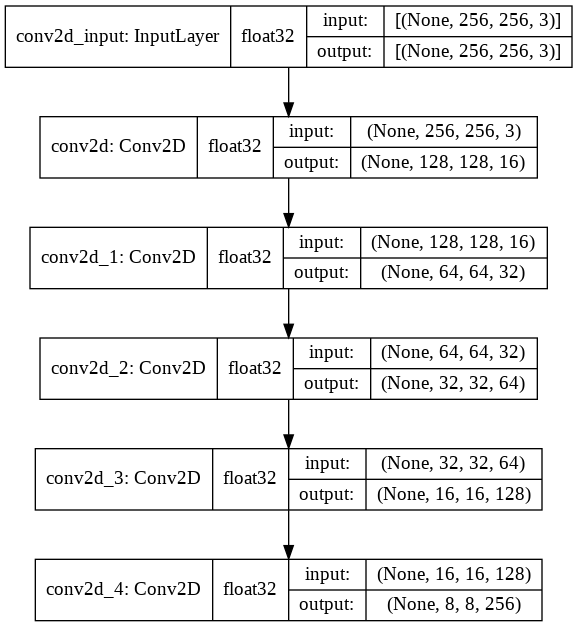

In [ ]:
# 인코더의 모양 조회

plot_model(encoder, show_dtype=True, show_shapes=True)

In [ ]:
with tf.device('/device:GPU:0'):
    # 인코더가 축소한 8*8*256 개의 데이터를 원래 모양인 256줄 256칸으로 복원
    decoder = Sequential([     
        # 128개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구           
        Conv2DTranspose(filters=128, kernel_size=3,  activation='relu', padding='same',strides=2,input_shape=(8,8,256)),
        # 64개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구     
        Conv2DTranspose(filters=64, kernel_size=3,  activation='relu', padding='same',strides=2),
        # 32개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구     
        Conv2DTranspose(filters=32, kernel_size=3,  activation='relu', padding='same',strides=2),
        # 16개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구     
        Conv2DTranspose(filters=16, kernel_size=3,  activation='relu', padding='same',strides=2),
        # 3개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구     
        Conv2DTranspose(filters=3, kernel_size=3,  activation='relu', padding='same',strides=2),
        # 1개의 필터로 합성곱 연산 
        Conv2D(3, kernel_size=(3,3), activation='relu', padding='same')
        ])

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 16)      4624      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 256, 256, 3)       435       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 3)       84        
Total params: 392,439
Trainable params: 392,439
Non-trainable params: 0
________________________________________________

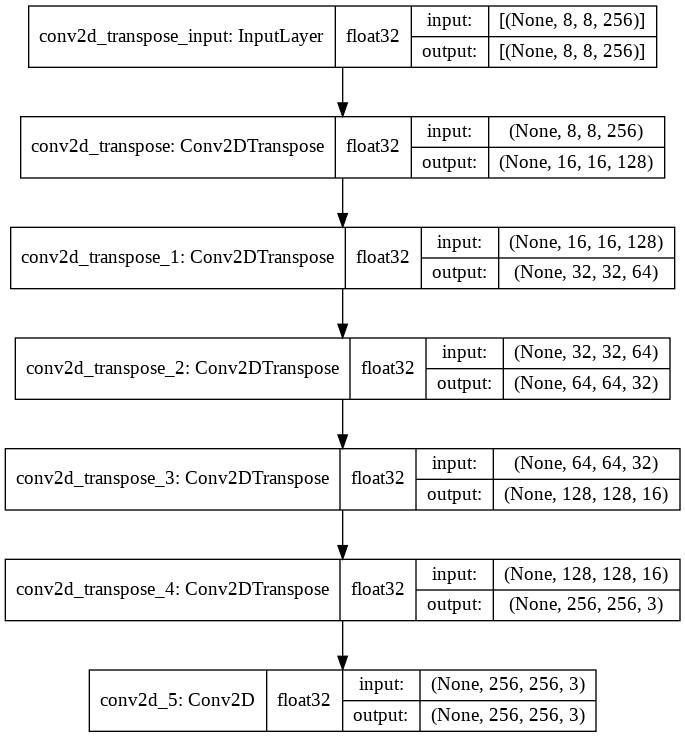

In [ ]:
# 디코더의 모양 조회
plot_model(decoder, show_dtype=True, show_shapes=True)

In [ ]:
class CNN_AutoEncoder(Model):
    #객체 생성시 실행되는 함수
    #인코더와 디코더를 입력 받아서 속성에 저장  
    def __init__(self,encoder, decoder):
        super(CNN_AutoEncoder, self).__init__()
        self.encoder = encoder

        self.decoder = decoder

    # 학습할때 실행되는 함수
    # 매개변수 x : 학습, 테스트 데이터
    def call(self, x):
        # 학습 또는 테스트 데이터를 encoder 연산 실행 (256줄 256칸의 데이터를 8*8*256개로 줄임 => 이미지의 중요한 정보만 남음 )  
        encoded = self.encoder(x)
        # 인코딩한 이미지의 중요한 정보를 이용해서 원래 이미지로 복원 
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
with tf.device('/device:GPU:0'):
    # 오토 인코더 객체 생성
    auto_encoder = CNN_AutoEncoder(encoder, decoder)

In [ ]:
with tf.device('/device:GPU:0'):
    # 오토인코더 옵티마이저 loss 함수 설정
    auto_encoder.compile(optimizer=Adam( learning_rate=0.001), loss=MeanSquaredError())

In [ ]:
with tf.device('/device:GPU:0'):
    # 빛번짐 이미지, 선명한 이미지의 학습이미지를 100개씩 리턴하는 객체 생성
    train_sequence = DenoisingSequence(train_inp_files, train_targ_files, 100)
    # 빛번짐 이미지, 선명한 이미지의 테스트이미지를 100개씩 리턴하는 객체 생성
    val_sequence = DenoisingSequence(test_inp_files, test_targ_files, 100)


In [ ]:
with tf.device('/device:GPU:0'):
    # auto_encoder 학습
    auto_encoder.fit(
            train_sequence, # 학습데이터를 리턴하는 객체   
            epochs= 30,      # 반복 횟수
            shuffle=True,   #데이터를 섞어서 학습 
            validation_data = val_sequence # 테스트 데이터를 리턴하는 객체
            )

   1/1386 [..............................] - ETA: 12:47:45 - loss: 0.1015

KeyboardInterrupt: ignored

In [ ]:
# 테스트 이미지를 예측하고 결과를 리턴하는 함수
# img_paths : 테스트 이미지들의 경로
# stride : 테스트 이미지를 stride 씩 잘라서 리턴
def predict(img_paths, stride=32, batch_size=100):
    results = []
    # img_paths : 테스트 이미지들의 경로
    # 1개를 img_path에 대입
    for img_path in img_paths:
        # img_path를 읽어서 img에 대입
        img = cv2.imread(img_path)
        # img를 float32로 변환하고 255로 나눔
        img = img.astype(np.float32)/255
        crop = []
        position = []
        batch_count = 0
        # 0이 저장된 img와 크기가 같은 배열 생성   
        result_img = np.zeros_like(img)
        # 0이 저장된 img와 크기가 같은 배열 생성
        voting_mask = np.zeros_like(img)
        # img.shape[0] : 이미지의 세로길이 리턴
        # 0 ~ 이미지의 세로 길이까지 stride씩 증가하면서 반복
        for top in tqdm(range(0, img.shape[0], stride)):
            # img.shape[1] : 이미지의 가로 길이 리턴
            # 0 ~ 이미지의 가로 길이까지 stride씩 증가하면서 반복
            for left in range(0, img.shape[1], stride):
                #np.zeros([img_size, img_size, 3], np.uint8) : img_size (256) 줄 img_size (256) 칸 의 0으로 저장된 배열 생성
                piece = np.zeros([img_size, img_size, 3], np.float32)
                # img 배열에서 top ~ top+img_size, left~left+img_size 까지의 데이터를 temp에 대입
                temp = img[top:top+img_size, left:left+img_size, :]
                # temp에 저장된 값을 piece배열의 [0~ temp의 줄, 0~temp의 칸, : ] 에 대입
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                #crop에 piece추가
                crop.append(piece)
                #posotion에 top,left추가
                position.append([top, left])
                # batch_count 1증가
                batch_count += 1
                # batch_count가 batch_size면
                if batch_count == batch_size:
                    # crop (빛반사 이미지가 저장)을 배열로 변환
                    crop = np.array(crop)
                    
                    #crop을 인코더로 압축
                    encoded_imgs = auto_encoder.encoder(crop).numpy()
                    # decoder로 원래 이미지로 복구
                    pred = auto_encoder.decoder(encoded_imgs).numpy() * 255
                    # crop 삭제
                    crop = []
                    # batch_count 0으로 추기화
                    batch_count = 0
                    # position에 저장된 top,left를 t,l에 대입
                    for num, (t, l) in enumerate(position):
                        # num번째 복구한 이미지를 piece에 대입
                        piece = pred[num]
                        # t~ t+img_size, l~ l+img_size, 3 을 h,w,c에 대입
                        h, w, c = result_img[t:t+img_size, l:l+img_size, :].shape
                        #piece에서 0~h,0~w까지를 result_img에 대입
                        result_img[t:t+img_size, l:l+img_size, :] += piece[:h, :w]
                        # t~ t+img_size, l~ l+img_size 에 1추가
                        voting_mask[t:t+img_size, l:l+img_size, :] += 1
                    position = []
        # result_img/voting_mask 계산
        result_img = result_img/voting_mask
        #result_img 를 정수로 변환
        result_img = result_img.astype(np.uint8)
        # results 에 result_img 대입
        results.append(result_img)
        
    return results

In [ ]:
result = predict(input_img_path + X_test_file_name[:5], 32)

100%|██████████| 77/77 [00:34<00:00,  2.23it/s]


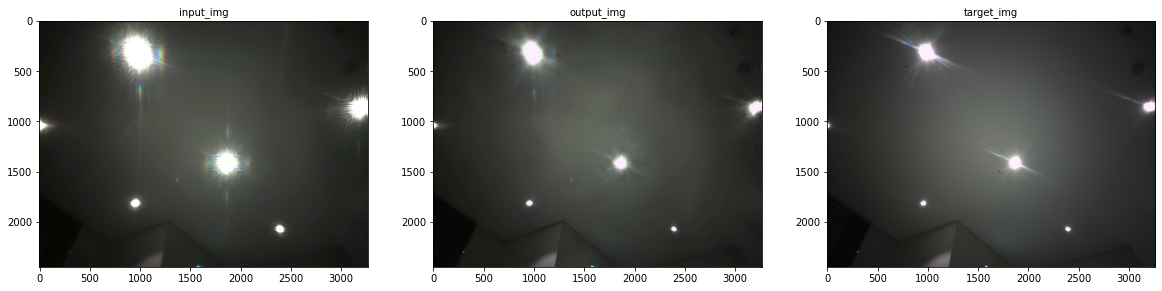

input PSNR : 21.319842770194096
output PSNR : 28.363052348823132 



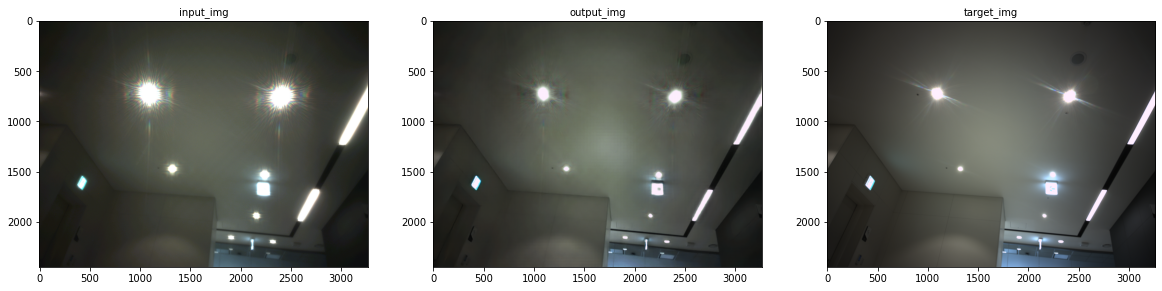

input PSNR : 20.699688771000467
output PSNR : 26.070890709152692 



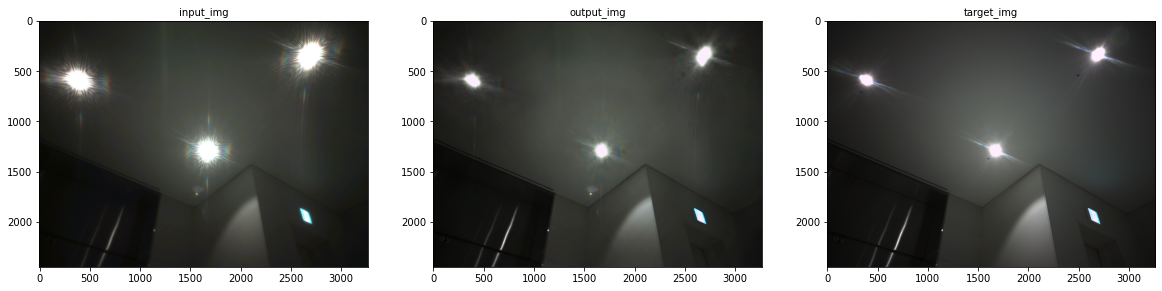

input PSNR : 21.733467472035976
output PSNR : 29.313979236345837 



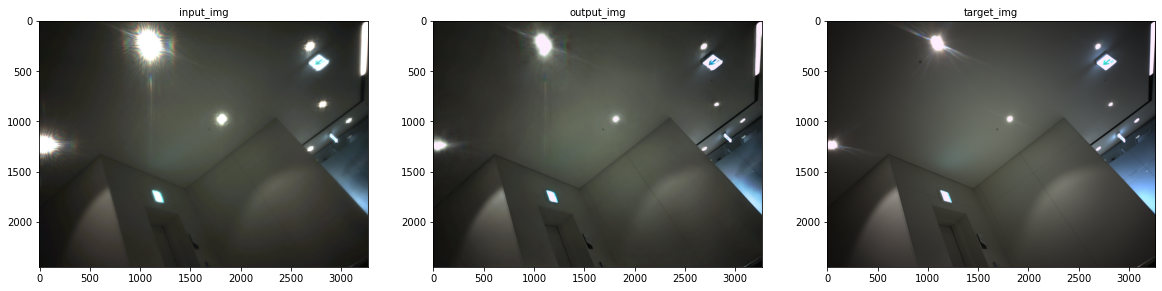

input PSNR : 20.92765411186867
output PSNR : 25.164551976910182 



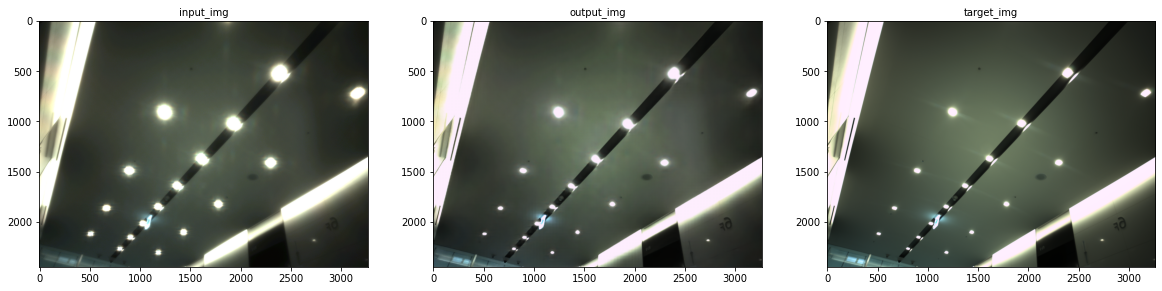

input PSNR : 21.007323217924263
output PSNR : 26.023537416033243 



In [ ]:
for i, (input_path, label_path) in enumerate(zip(input_img_path + X_test_file_name[:5], label_img_path + y_test_file_name[:5])):
    # input_path (빛번짐 이미지 경로) 를 읽음
    input_img = cv2.imread(input_path)
    #input_img (빛번짐 이미지) 를 컬러로 변환
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    # label_path (선명한 이미지 경로) 를 읽음
    targ_img = cv2.imread(label_path)
    #targ_img (빛번짐 이미지) 를 컬러로 변환
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    # i번째 복구 이미지를 pred_img에 대입
    pred_img = result[i]
    #pred_img (오토 인코더로 복구 이미지) 를 컬러로 변환
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(input_img) # 빛번짐 이미지
    plt.title('input_img', fontsize=10)
    plt.subplot(1,3,2)
    plt.imshow(pred_img) # 선명한 이미지
    plt.title('output_img', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(targ_img) # 오토 인코더로 복구한 이미지
    plt.title('target_img', fontsize=10)
    plt.show()
